# Clustering Web URLs into Communities with PySpark GraphFrames
In this notebook, we look to apply big data techniques to analyze large-scale web crawl data from the [Common Crawl dataset](http://commoncrawl.org/), which is an open dataset hosted by Amazon Web Services. We got our inspiration for this task from this excellent [Medium blog post](https://towardsdatascience.com/large-scale-graph-mining-with-spark-part-2-2c3d9ed15bb5) by Win Suen on the same topic (thanks, Win!). 

While it is possible to analyze Common Crawl web data by looking at specific words inside the HTML source of a web page, that would be a humongous task considering the size of the dataset (several petabytes!) - hence, this is a good use case for graph analysis. There have been many interesting applications of graph analysis on datasets in biology, sociology and computer science, and with the availability of free and open web crawl data thanks to Common Crawl, we can now apply this at scale to study the relationships between domains as well. Graphs are a useful tool in this case because it allows us to study the links between domains *using nothing but the intrinsic information contained inside the URL's href tags*. We can create community clusters of domains by just studying the "child links", i.e. the outgoing links from a particular web page. 

## Goals
Our goal is to extend on the upstream and downstream parts of the actual graph analysis from Win's [original notebook](https://github.com/wsuen/pygotham2018_graphmining/blob/master/notebooks/Graphframes_demo.ipynb), and to document any interesting observations that we make. We intend to use PySpark to extract and transform our web URL data, and add visualization techniques wherever possible so that we know what data we're dealing with.

All our ETL and visualization code is published in this repository.

## Import the necessary modules

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.6.0-spark2.3-s_2.11 pyspark-shell'
import pyspark
from pyspark.sql import * 
from pyspark.sql.functions import udf, col, desc
import hashlib
import numpy as np
import pandas as pd
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
sc = pyspark.SparkContext("local[*]")
spark = SparkSession.builder.appName('notebook').getOrCreate()

In [3]:
from graphframes import *
import hashlib

## Read in data
Our PySpark ETL code in ```parent_child.py``` extracts relevant URLs from the CommonCrawl WARC files and outputs them to parquet files. We now read them in for community clustering analysis.

In [4]:
sqlContext = SQLContext(sc)
df = sqlContext.read.parquet("./bootstrap/spark-warehouse/may/may*")

In [5]:
df.show(5)

+--------------------+--------------------+-----------+--------------------+-----------+------------+
|              parent|           parentTLD|   childTLD|               child|childDomain|parentDomain|
+--------------------+--------------------+-----------+--------------------+-----------+------------+
|http://1separable...|1separable-43v3r....|twitter.com|http://twitter.co...|    twitter|     skyrock|
|      http://3msk.ru|             3msk.ru|    k--k.ru|http://k--k.ru/85...|       k--k|        3msk|
|      http://3msk.ru|             3msk.ru|    com9.ru|http://com9.ru/85...|       com9|        3msk|
|      http://3msk.ru|             3msk.ru|    com9.ru|http://com9.ru/85...|       com9|        3msk|
|      http://3msk.ru|             3msk.ru| top.vy3.ru|http://top.vy3.ru...|        vy3|        3msk|
+--------------------+--------------------+-----------+--------------------+-----------+------------+
only showing top 5 rows



## Extract domain names to visualize in a WordCloud
To more visually inspect our data, it makes sense to see what URL domain names dominate in the subset of the common crawl data that we sampled. To do this, we look at the ```childDomain``` column. Looking at this particular column tells us which domains receive a high number of incoming links.

First, we extract the data and store as a list.

In [6]:
# Collect domain names
doms = [i.childDomain for i in df.distinct().collect()]
# Combine all items of domain list into one document
domain_names = ' '.join(doms)
print(doms[:10])

['okinan', 'deviantart', 'zenax', 'gold-ankaufen-stuttgart', 's35k', 'dikkemeiden', 'romemonuments', 'instagram', '283662', '566872']


To visualize this information, we just store the domain names as one giant string separated by spaces.

### Generate WordCloud
A [WordCloud](https://github.com/amueller/word_cloud) is a good way to visualize the relative importance of words in a large list of words. This is done by putting the words in a "cloud" and sizing the more frequently occuring words larger than others. A quick glance at the below plot shows us what domain names dominate in our dataset. We can decide how to subset and filter this data for graph calculations at a later stage.

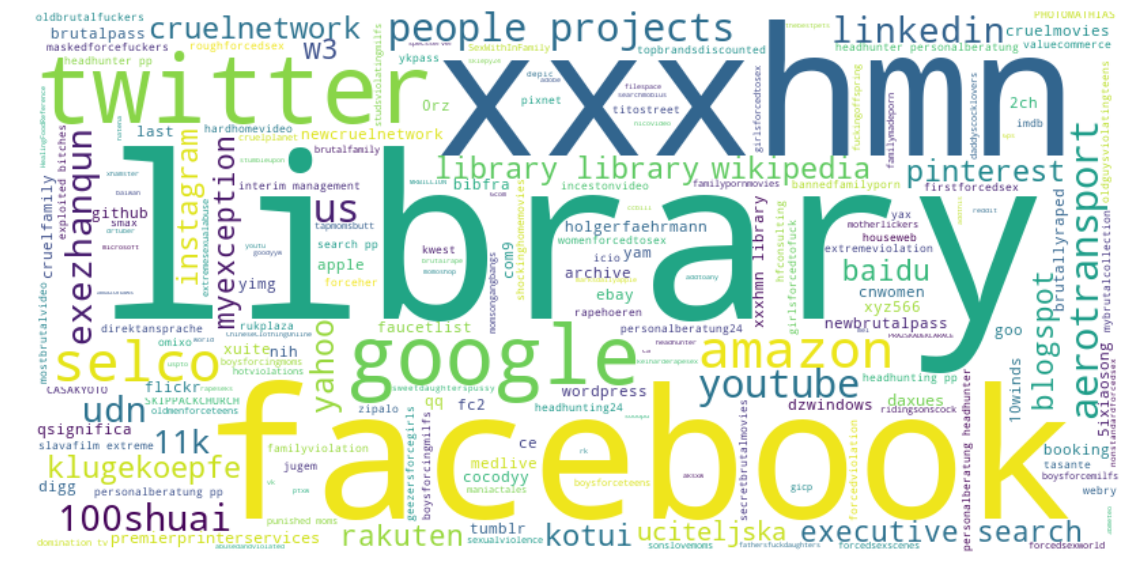

In [7]:
% matplotlib inline
# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, background_color="white").\
generate(domain_names)
# Display the generated image:
plt.figure(figsize=(20, 10));
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis("off");
plt.show();

As we might expect, we see familiar domain names like Twitter, Facebook and Google and YouTube dominate in our dataset, since these are pointed to by many other websites. In this subset however, there are a significant number of adult websites! We might want to look at filtering these links out upstream, or just ignore them and focus on a subset of these links for graph analysis.

### Visualize a subset of the data
Most of the domain names we visualized above are not very useful. For a more directed analysis, we visualize just a subset of the data with common children as below. 

In [8]:
focus = ['amazon', 'etsy', 'ebay']
df = df.filter(df.childDomain.isin(focus))
print(df.count())
df.show(10)

17746
+--------------------+--------------------+--------------+--------------------+-----------+----------------+
|              parent|           parentTLD|      childTLD|               child|childDomain|    parentDomain|
+--------------------+--------------------+--------------+--------------------+-----------+----------------+
|http://earthnotes...|earthnotes.tripod...|    amazon.com|http://www.amazon...|     amazon|          tripod|
|http://www.mycath...|mycatholicsource.com|    amazon.com|https://www.amazo...|     amazon|mycatholicsource|
| http://deepkick.com|        deepkick.com|  amazon.co.jp|http://www.amazon...|     amazon|        deepkick|
|http://www.defaul...|    defaultlogic.com|rover.ebay.com|http://rover.ebay...|       ebay|    defaultlogic|
|http://www.defaul...|    defaultlogic.com|rover.ebay.com|http://rover.ebay...|       ebay|    defaultlogic|
|http://www.defaul...|    defaultlogic.com|rover.ebay.com|http://rover.ebay...|       ebay|    defaultlogic|
|http://www.d

In [9]:
# Select set of parents and children TLDs (nodes) to assign id for each node.
assignID = df.select("parentTLD","childTLD").rdd.flatMap(lambda x: x).distinct()

### Assign unique hashkeys to each item in the nodelist

In [10]:
def hashnode(x):
    # Assign unique 8-digit hex hashkey to each item
    return hashlib.sha1(x.encode("UTF-8")).hexdigest()[:8]
hashnode_udf = udf(hashnode)

### Define graph vertices

In [11]:
vertices = assignID.map(lambda x: (hashnode(x), x)).toDF(["id","name"])
vertices.show(5)

+--------+--------------------+
|      id|                name|
+--------+--------------------+
|5ba48373|     99l.iraq273.com|
|a01f635b|       asnotedin.com|
|ab3c162b|      gogocycles.com|
|a2532123|             mix1.de|
|510a89c2|douglashistory.co.uk|
+--------+--------------------+
only showing top 5 rows



### Define graph edges 

In [12]:
edges = df.select("parentTLD","childTLD")\
    .withColumn("src", hashnode_udf("parentTLD"))\
    .withColumn("dst", hashnode_udf("childTLD"))\
    .select("src","dst")
edges.show(5)

+--------+--------+
|     src|     dst|
+--------+--------+
|66a801fe|d70108eb|
|71432283|d70108eb|
|ad79bf2c|aafe6c25|
|7ff5c566|5a76b5f8|
|7ff5c566|5a76b5f8|
+--------+--------+
only showing top 5 rows



### Create GraphFrame in PySpark

In [13]:
graph = GraphFrame(vertices, edges)

## Run Label-Propagation Analysis (LPA)
LPA is a community detection algorithm for large-scale graph networks [Original paper](https://arxiv.org/pdf/0709.2938.pdf). The main benefit of using LPA is that it does not require any prior labeling of the dataset prior to community detection - the algorithm iteratively connects groups of nodes based on a consensus of unique labels using the intrinsic information in the graph itself! 

LPA is implemented in PySpark graphframes and is run as shown below. 

In [14]:
communities = graph.labelPropagation(maxIter=5)
communities.persist().show(10)

+--------+--------------------+-------------+
|      id|                name|        label|
+--------+--------------------+-------------+
|9719ef07|       zenaneren.org|1082331758599|
|9ad615a2|content.rotowire.com| 609885356038|
|14a31529|paolapittalis.scr...|1288490188801|
|d0444ccd|lmpy.sengoku-jida...|1082331758599|
|b88e9cb3|   christinetsai.com| 386547056641|
|190e5a58|     khd.sphi300.com|            2|
|d0e71710|     feedlisting.com| 962072674306|
|e2f4e23a|           dtruk.com|            2|
|54d4f49c|    michaellanza.com| 609885356038|
|bb7a7ddd|      techno4ever.fm| 523986010112|
+--------+--------------------+-------------+
only showing top 10 rows



## Which are the largest identified communities?

In [15]:
labelcount = communities.groupby('label').count().sort(desc('count')).limit(10)
labelcount.show()

+-------------+-----+
|        label|count|
+-------------+-----+
| 609885356038|  459|
|1082331758599|  223|
|            2|   95|
| 523986010112|   87|
|  68719476738|   46|
| 635655159808|   39|
| 386547056641|   36|
| 962072674306|   32|
|1614907703296|   15|
| 481036337154|   13|
+-------------+-----+



In [16]:
t = labelcount.select('label').collect()
top10 = [str(i.label) for i in t]
top10

['609885356038',
 '1082331758599',
 '2',
 '523986010112',
 '68719476738',
 '635655159808',
 '386547056641',
 '962072674306',
 '1614907703296',
 '481036337154']

In [17]:
communities.filter(communities.label.isin(top10)).show(10)

+--------+--------------------+-------------+
|      id|                name|        label|
+--------+--------------------+-------------+
|9719ef07|       zenaneren.org|1082331758599|
|9ad615a2|content.rotowire.com| 609885356038|
|d0444ccd|lmpy.sengoku-jida...|1082331758599|
|b88e9cb3|   christinetsai.com| 386547056641|
|190e5a58|     khd.sphi300.com|            2|
|d0e71710|     feedlisting.com| 962072674306|
|e2f4e23a|           dtruk.com|            2|
|54d4f49c|    michaellanza.com| 609885356038|
|bb7a7ddd|      techno4ever.fm| 523986010112|
|82a74399|             ebay.nl| 481036337154|
+--------+--------------------+-------------+
only showing top 10 rows



## Run PageRank

Given a particular graph structure, running a PageRank analysis computes a score for each vertex of the graph depending on how many other vertices point to it. Looking at the graph this way allows us to pinpoint nodes of "high centrality" very easily. A full PageRank analysis requires around 15-20 iterations, but for efficiency we only run for 3 iterations below. 

In [18]:
results = graph.pageRank(resetProbability=0.01, maxIter=3)
results.vertices.select("id", "pagerank")\
    .join(vertices, on="id").orderBy("pagerank", ascending=False)\
    .show(5)

+--------+------------------+------------+
|      id|          pagerank|        name|
+--------+------------------+------------+
|d70108eb|202.71531353669056|  amazon.com|
|aafe6c25| 115.5061021176177|amazon.co.jp|
|14641d80|  44.3553437217109|   amazon.de|
|56cea5c2|  43.5680277141005|    ebay.com|
|7c7e1e84| 30.31395629135096|   amazon.cn|
+--------+------------------+------------+
only showing top 5 rows



In [19]:
print('Ran pagerank for {} vertices'.format(results.vertices.count()))

Ran pagerank for 1283 vertices
